In [1]:
%load_ext autoreload
%autoreload 2
from gfbm.models.alpha_diff import AlphaDiffGratin, AlphaDiff
from gfbm.layers.encoders import TrajsEncoderLSTM
from gfbm.data_tools.datamodule import DataModule
from glob import glob
from fbm import fbm
from pytorch_lightning import Trainer
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from gfbm.utils import fbm_covar, min_variance, ML_matrices_just_alpha, estimate_true_posterior
from tqdm import tqdm

/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dl_params = {"batch_size":8,"num_workers":10}
dl_params_single = {"batch_size":1,"num_workers":1}
ds_params = {
    "N":int(1e4),
    "dim":1,
    "noise":0,
    "vary_tau":False,
    "length_range":(10,10000),
    "length_sampling":"linear"}
graph_info = {"degree":20}
export_path = "/home/hverdier/Gaia/hecat/hippo/models/fbm/"


In [3]:
dm = DataModule(dl_params=dl_params,ds_params=ds_params,graph_info=graph_info)
dm.setup()
#example_data = dm.ds_train[0]

Prepare datasets
stage is None, strange...
Creating new train fBMTrajDataset, seed=0
seed_offset = 0


In [4]:
#"Gratin_InstanceNorm_32"
f = glob(os.path.join(export_path,"tb_logs","Gratin_good","version_1","checkpoints","*"))[0]
f_lstm = glob(os.path.join(export_path,"tb_logs","LSTM","version_4","checkpoints","*"))[0]
model_name = "Gratin"

In [5]:
glob(os.path.join(export_path,"tb_logs","LSTM","version_4","checkpoints","*"))

['/home/hverdier/Gaia/hecat/hippo/models/fbm/tb_logs/LSTM/version_4/checkpoints/epoch=49-step=4900.ckpt']

In [6]:
model = AlphaDiffGratin.load_from_checkpoint(f)
model_lstm = AlphaDiff.load_from_checkpoint(f_lstm,encoder=TrajsEncoderLSTM(latent_dim=12))
models = {"gratin":model,"lstm":model_lstm}

['step_std']


RuntimeError: Error(s) in loading state_dict for AlphaDiffGratin:
	Unexpected key(s) in state_dict: "encoder.pooling.gate_nn.0.1.bias", "encoder.pooling.gate_nn.0.1.weight_g", "encoder.pooling.gate_nn.0.1.weight_v", "encoder.pooling.gate_nn.1.1.bias", "encoder.pooling.gate_nn.1.1.weight_g", "encoder.pooling.gate_nn.1.1.weight_v". 
	size mismatch for encoder.mlp.0.1.weight: copying a param with shape torch.Size([128, 98]) from checkpoint, the shape in current model is torch.Size([128, 97]).

In [15]:
trainer = Trainer(gpus=1,deterministic=False)

/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
def predict_with_model(model, dm):
    res = trainer.predict(model, datamodule=dm)
    true_alpha = []
    pred_alpha = []
    length = []
    for pred, true, length_ in res:
        true_alpha.append(true[:,1])
        pred_alpha.append(pred[:,1])
        length.append(length_)
    true_alpha = torch.cat(true_alpha,dim=0)
    pred_alpha = torch.cat(pred_alpha,dim=0)
    length = torch.cat(length,dim=0)[:,0]
    return true_alpha, pred_alpha, length

In [17]:
alpha_pred = {}
alpha_true = {}
Ns = np.logspace(1,4,num=20,dtype=int)
for model_name, model in models.items():
    for N in Ns:
        ds_N = dict(ds_params)
        ds_N["length_range"] = (N,N+1)
        ds_N["logdiff_range"] = (0.,0.)
        BS = 128 if N <= 1000 else 8
        dm_N = DataModule(dl_params={"batch_size":BS,"num_workers":10},ds_params=ds_N,graph_info=graph_info)
        alpha_true[(model_name,N)], alpha_pred[(model_name,N)], _ = predict_with_model(model, dm=dm_N)

Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 21.76it/s]
Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 22.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:02<00:00, 28.05it/s]
Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 23.89it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 24.87it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 22.96it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 19.41it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 16.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:07<00:00, 11.09it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:08<00:00,  8.91it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:10<00:00,  7.51it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:20<00:00,  3.77it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [00:54<00:00, 22.85it/s]
Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [01:05<00:00, 19.10it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [01:21<00:00, 15.36it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [01:47<00:00, 11.61it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [02:26<00:00,  8.53it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [03:20<00:00,  6.24it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [04:45<00:00,  4.38it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0:   6%|▋         | 5/79 [00:00<00:03, 21.69it/s]

/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  return F.conv1d(input, weight, bias, self.stride,


Predicting DataLoader 0: 100%|██████████| 79/79 [00:02<00:00, 26.71it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 25.77it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 25.11it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 23.08it/s]
Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 22.70it/s]
Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 20.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 18.48it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 15.66it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.54it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:08<00:00,  9.11it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:10<00:00,  7.60it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:15<00:00,  5.08it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [02:02<00:00, 10.17it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [02:45<00:00,  7.56it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [03:44<00:00,  5.58it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [05:08<00:00,  4.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [07:14<00:00,  2.88it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [10:18<00:00,  2.02it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 1250/1250 [14:51<00:00,  1.40it/s]


In [19]:
alpha_values = np.linspace(0.4,1.6,200,endpoint=True)
sigma_values = []
min_v = {}
for N in tqdm(Ns):
    for alpha in alpha_values:
        S, d_S, S_inv = fbm_covar(L=N, alpha=alpha, sigma=0.)
        min_v[(N,alpha)] = min_variance(d_S, S_inv)

 80%|████████  | 16/20 [40:10<10:02, 150.66s/it]


KeyboardInterrupt: 

In [ ]:
Cs, inv_Cs, logdet = ML_matrices_just_alpha(Ns, alpha_values)

In [ ]:
MLE_se = {}
trajs_per_N = int(1e2)
for N in tqdm(Ns):
    MLE_se[N] = np.zeros(trajs_per_N)
    for i in range(trajs_per_N):
        alpha = np.random.uniform(0.4,1.6)
        traj = fbm(int(N)-1,hurst=alpha/2,length=int(N))
        _, p = estimate_true_posterior(traj, logdets=logdet,inv_Cs=inv_Cs, alpha_values=alpha_values)
        estimated_alpha = alpha_values[np.argmax(p)]
        MLE_se[N][i] = (alpha-estimated_alpha)**2


 15%|█▌        | 3/20 [00:03<00:18,  1.11s/it]


KeyboardInterrupt: 

gratin : exposant SE : -0.09 
gratin : exposant Var : -0.21 
lstm : exposant SE : -0.03 
lstm : exposant Var : -0.17 


NameError: name 'MLE_se' is not defined

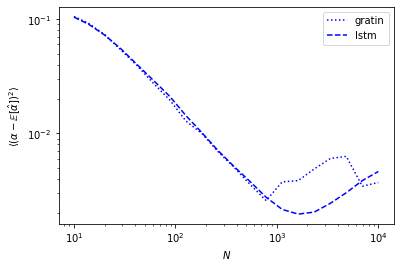

In [22]:
plt.figure()
mean_pred_alpha = {}
for model_name, model in models.items():
    for N in Ns:
        mean_pred_alpha[(model_name,N)] = torch.mean(alpha_pred[(model_name,N)],dim=-1)
    se = [torch.mean((mean_pred_alpha[(model_name,N)]-alpha_true[(model_name,N)])**2) for N in Ns]
    var = [torch.mean(torch.var(alpha_pred[(model_name,N)],dim=-1)) for N in Ns]
    n = len(se)
    half = n//2
    print("%s : exposant SE : %.2f " % (model_name,torch.log10(se[half]/se[-1]) / np.log10(Ns[half]/Ns[-1])))
    print("%s : exposant Var : %.2f " % (model_name, torch.log10(var[half]/var[-1]) / np.log10(Ns[half]/Ns[-1])))

    plt.plot(Ns, se,":" if model_name == "gratin" else "--",label=model_name,ms=4,c="blue")
    #plt.plot(Ns, var,"--",label="Var$(\\hat{\\alpha})$",ms=4,c="blue")
plt.ylabel("$\langle (\\alpha - \mathbb{E}\left[\\hat{\\alpha}\\right])^2 \\rangle$ ")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$N$")
plt.legend()
ml = [np.mean(MLE_se[N]) for N in Ns]
cr = [np.mean([min_v[(N,alpha)] for alpha in alpha_values]) for N in Ns]

print("exposant CR : %.2f " % (np.log10(cr[half]/cr[-1]) / np.log10(Ns[half]/Ns[-1])))




plt.plot(Ns, ml, "dashdot",label="MLE",c="blue")
plt.plot(Ns, cr, label="Cramer-Rao",c="blue")
plt.legend()

plt.tight_layout()

In [17]:
reduced_N = [40,200,1000]
reduced_alpha = [.5,1.,1.5]
reduced_alpha_true = {}
reduced_alpha_pred = {}
for N in reduced_N:
    for alpha in reduced_alpha:
        ds_N = dict(ds_params)
        ds_N["length_range"] = (N,N+1)
        ds_N["logdiff_range"] = (0.,0.)
        ds_N["alpha_range"] = (alpha, alpha)
        dm_N = DataModule(dl_params=dl_params,ds_params=ds_N,graph_info=graph_info)
        reduced_alpha_true[(N,alpha)], reduced_alpha_pred[(N,alpha)], _ = predict_with_model(model, dm=dm_N)
    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/hverdier/miniconda3/envs/gfbm/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 25.71it/s]
Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:02<00:00, 28.50it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 25.64it/s]
Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 11.49it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 16.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:07<00:00, 11.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:28<00:00,  2.80it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:20<00:00,  3.89it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:27<00:00,  2.91it/s]


In [18]:
reduced_N_2 = [40,200,1000]
reduced_alpha = [.5,1.,1.5]
reduced_alpha_true_2 = {}
reduced_alpha_pred_2 = {}
for N in reduced_N_2:
    ds_N = dict(ds_params)
    ds_N["length_range"] = (N,N+1)
    ds_N["logdiff_range"] = (0.,0.)
    dm_N = DataModule(dl_params=dl_params,ds_params=ds_N,graph_info=graph_info)
    reduced_alpha_true_2[N], reduced_alpha_pred_2[N], _ = predict_with_model(model, dm=dm_N)
    

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:03<00:00, 23.17it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:07<00:00, 10.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


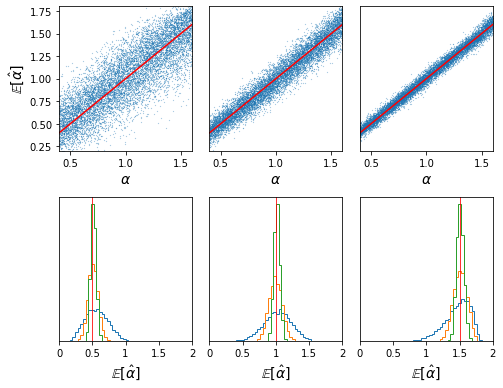

In [61]:
fig = plt.figure(figsize=(7,5.5))
for i, N in enumerate(reduced_N_2):
    ax = fig.add_subplot(2,3,i+1)
    ax.scatter(reduced_alpha_true_2[N],torch.mean(reduced_alpha_pred_2[N],dim=-1),s=.02)
    ax.plot([.4,1.6],[.4,1.6],c="red")
    ax.set_xlim((.4,1.6))
    ax.set_ylim((.2,1.8))
    ax.set_xlabel("$\\alpha$",fontsize=14)
    if i > 0:
        ax.set_yticks([])
    else:
        ax.set_ylabel("$\mathbb{E}\left[\hat{\\alpha}\\right]$",fontsize=14)
for i, alpha in enumerate(reduced_alpha):
    ax = fig.add_subplot(2,3,i+4)
    for N in reduced_N:
        ax.hist(torch.mean(reduced_alpha_pred[(N,alpha)],dim=-1),bins=50,histtype="step",range=(0.,2.),density=True)
    ax.set_xlim((0.,2.))
    ax.set_yticks([])
    ax.set_xticks([0,.5,1.,1.5,2.],["0","0.5","1","1.5","2"])
    ax.set_xlabel("$\mathbb{E}\left[\hat{\\alpha}\\right]$",fontsize=14)
    ax.axvline(alpha,c="red",lw=.8)
plt.tight_layout()

In [12]:
model.freeze()
model.eval();

Prepare datasets
stage is None, strange...
Creating new train fBMTrajDataset, seed=0
seed_offset = 0
Prepare datasets
seed_offset = 10000
Test dataloader


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

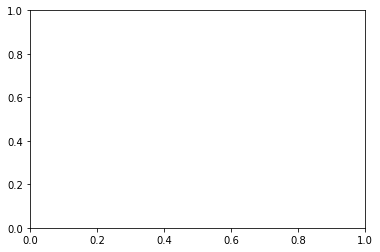

In [15]:
for N in [10,100,1000]:
    for alpha in [0.5,1.,1.5]:
        ds_params_L = dict(ds_params)
        ds_params_L.update({"length_range":(N,N+1),"alpha_range":(alpha,alpha)})
        dm_single = DataModule(dl_params=dl_params_single,ds_params=ds_params_L ,graph_info=graph_info)
        dm_single.setup()

        for batch in dm_single.test_dataloader():
            pred, true, L = model.forward(batch,sample=True,n_repeats=2000)
            break

        plt.figure()
        plt.hist(pred[:,1],bins=50)
        plt.axvline(true[0,1],c="red")
        plt.xlim((0.4,1.6))
        plt.title("L = %d | $\\alpha$ = %.2f" % (L,alpha))

In [14]:
N = 100
true_alpha = {}
pred_alpha = {}
for alpha in np.linspace(0.4,1.6,25):
    ds_params_alpha = dict(ds_params)
    ds_params_alpha.update({"length_range":(N,N+1),"alpha_range":(alpha,alpha),"N":int(1e4)})
    dm_alpha = DataModule(ds_params=ds_params_alpha,dl_params=dl_params,graph_info=graph_info)
    trainer = Trainer(gpus=1,deterministic=False)
    true_alpha[alpha], pred_alpha[alpha], _ = predict_with_model(model, dm_alpha)
    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.32it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.91it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 13.06it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.92it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.45it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.29it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.98it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.37it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.93it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 13.08it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.34it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.22it/s]

GPU available: True, used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 17.45it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.24it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.96it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.89it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 13.13it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.58it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.59it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.94it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.94it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Prepare datasets
seed_offset = 10000


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.61it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:05<00:00, 13.80it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Prepare datasets

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 11.77it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Prepare datasets
seed_offset = 10000
Prepare datasets
seed_offset = 10000
Test dataloader
Predicting DataLoader 0: 100%|██████████| 79/79 [00:06<00:00, 12.36it/s]


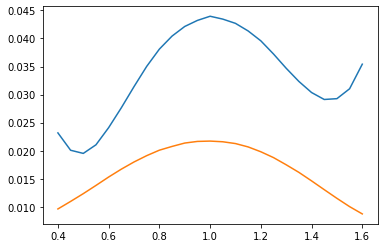

In [15]:
plt.plot([alpha for alpha in pred_alpha],[torch.mean((pred_alpha[alpha] - alpha)**2) for alpha in pred_alpha])
plt.plot([alpha for alpha in pred_alpha],[torch.mean(torch.var(pred_alpha[alpha],dim=-1)) for alpha in pred_alpha])